In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from datetime import datetime

import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Data

## Download

In [3]:
url = "https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv"
df = pd.read_csv(url)
df.to_csv('japan_cars_dataset.csv', index=False)

In [4]:
df = df.dropna()

df.head(10)

,Unnamed: 0,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,0,80,nissan,march,2003,80000,1240,at,2wd,rhd,gasoline
1,1,110,nissan,march,2010,53000,1200,at,2wd,rhd,gasoline
2,2,165,nissan,lafesta,2005,47690,2000,at,2wd,rhd,gasoline
3,3,190,toyota,avensis,2008,130661,1990,at,2wd,rhd,gasoline
4,4,190,daihatsu,mira,2006,66300,660,at,2wd,rhd,gasoline
5,5,190,daihatsu,mira,2004,81400,660,at,2wd,rhd,gasoline
6,8,220,nissan,march,2010,117000,1200,at,2wd,rhd,gasoline
7,9,230,volkswagen,passat,2008,127763,3190,at,4wd,rhd,gasoline
8,10,275,mazda,bongo van,2010,178218,1800,mt,2wd,rhd,gasoline
9,11,283,honda,step wgn,2005,121655,2000,at,2wd,rhd,gasoline


In [5]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.head()

,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,80,nissan,march,2003,80000,1240,at,2wd,rhd,gasoline
1,110,nissan,march,2010,53000,1200,at,2wd,rhd,gasoline
2,165,nissan,lafesta,2005,47690,2000,at,2wd,rhd,gasoline
3,190,toyota,avensis,2008,130661,1990,at,2wd,rhd,gasoline
4,190,daihatsu,mira,2006,66300,660,at,2wd,rhd,gasoline


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   price            2318 non-null   int64 
 1   mark             2318 non-null   object
 2   model            2318 non-null   object
 3   year             2318 non-null   int64 
 4   mileage          2318 non-null   int64 
 5   engine_capacity  2318 non-null   int64 
 6   transmission     2318 non-null   object
 7   drive            2318 non-null   object
 8   hand_drive       2318 non-null   object
 9   fuel             2318 non-null   object
dtypes: int64(4), object(6)
memory usage: 181.2+ KB


## Preprocessing

In [7]:
df[['price', 'year', 'mileage', 'engine_capacity']].describe()

,price,year,mileage,engine_capacity
count,2318.000000,2318.000000,2318.000000,2318.000000
mean,971.522433,2005.972390,100013.194996,1507.010785
std,288.673112,3.698863,52512.478883,549.585170
min,80.000000,1979.000000,2000.000000,9.000000
25%,776.000000,2004.000000,67000.000000,1300.000000
50%,1000.000000,2006.000000,94000.000000,1490.000000
75%,1213.000000,2009.000000,124000.000000,1800.000000
max,1400.000000,2015.000000,790000.000000,12340.000000


In [8]:
df['car_age'] = 2015 - df['year']  # Возраст авто
df['mileage_per_year'] = df['mileage'] / (df['car_age'] + 1)

df = df[df['year'] >= 1990]
df = df[df['mileage'] <= 300000]
df = df[(df['engine_capacity'] >= 600) & (df['engine_capacity'] <= 4000)]
df = df[(df['price'] >= 200) & (df['price'] <= 1250)]

In [9]:
df[['price', 'year', 'mileage', 'engine_capacity']].describe()

,price,year,mileage,engine_capacity
count,1841.000000,1841.000000,1841.000000,1841.000000
mean,885.060293,2006.108637,98011.152091,1483.568169
std,249.098905,3.589861,44805.922027,485.352738
min,220.000000,1990.000000,2000.000000,650.000000
25%,700.000000,2004.000000,66000.000000,1290.000000
50%,920.000000,2006.000000,93000.000000,1490.000000
75%,1100.000000,2009.000000,122676.000000,1780.000000
max,1250.000000,2015.000000,296910.000000,3690.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1841 entries, 6 to 1857
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             1841 non-null   int64  
 1   mark              1841 non-null   object 
 2   model             1841 non-null   object 
 3   year              1841 non-null   int64  
 4   mileage           1841 non-null   int64  
 5   engine_capacity   1841 non-null   int64  
 6   transmission      1841 non-null   object 
 7   drive             1841 non-null   object 
 8   hand_drive        1841 non-null   object 
 9   fuel              1841 non-null   object 
 10  car_age           1841 non-null   int64  
 11  mileage_per_year  1841 non-null   float64
dtypes: float64(1), int64(5), object(6)
memory usage: 187.0+ KB


In [12]:
cat_features = ['mark', 'model', 'transmission', 'drive', 'hand_drive', 'fuel']

In [13]:
model_counts = df['model'].value_counts()
df['model'] = df['model'].where(model_counts[df['model']].values >= 10, 'other')

In [15]:
cat_features = ['mark', 'model', 'transmission', 'drive', 'hand_drive', 'fuel']
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

In [16]:
num_features = ['year', 'mileage', 'engine_capacity', 'car_age', 'mileage_per_year']


In [17]:
scaler = StandardScaler()
df_encoded[num_features] = scaler.fit_transform(df_encoded[num_features])

df_encoded['price_log'] = np.log1p(df_encoded['price'])

## Train/Val/Test

In [19]:
X = df_encoded.drop(columns=['price', 'price_log'])
y = df_encoded['price_log']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
print(X_train.shape, X_val.shape, X_test.shape)

(1288, 69) (276, 69) (277, 69)


# Model

## Create

In [21]:
input_layer = Input((X_train.shape[1],))

x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(16, activation='relu')(x)

output = Dense(1, activation='linear')(x)
model = Model(input_layer, output)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

## Callbacks

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=80,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=25,
    min_lr=1e-7,
    verbose=1
)

## Train

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34.4313 - mae: 5.6164 - val_loss: 37.5286 - val_mae: 6.0321 - learning_rate: 0.0010
Epoch 2/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.4531 - mae: 4.0140 - val_loss: 27.2402 - val_mae: 5.0989 - learning_rate: 0.0010
Epoch 3/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.4270 - mae: 2.6998 - val_loss: 16.8354 - val_mae: 3.9353 - learning_rate: 0.0010
Epoch 4/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0550 - mae: 1.8902 - val_loss: 9.3552 - val_mae: 2.8518 - learning_rate: 0.0010
Epoch 5/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2901 - mae: 1.4995 - val_loss: 5.3368 - val_mae: 2.0476 - learning_rate: 0.0010
Epoch 6/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5500 - mae: 1.3407 - val_loss: 3.4275 - val_mae: 1.5209 - learning_rate: 0.0010
Epoch 7/400
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2783 - mae: 1.2521 - val_loss: 2.5331 - val_mae: 1.2217 - learning_rate: 0.0010
Epoch 8

## Charts

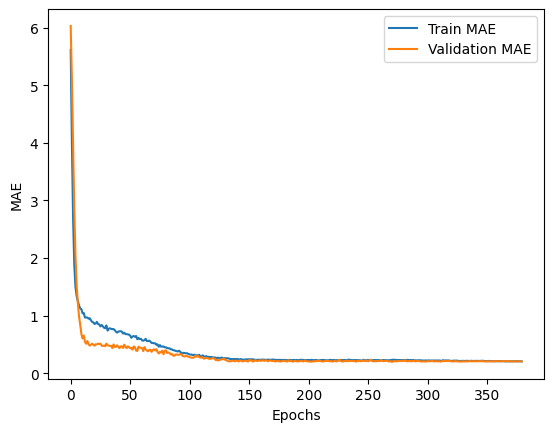

In [25]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Test

In [26]:
y_pred_log = model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

mse = mean_squared_error(y_test_original, y_pred)
print(f"MSE на тестовой выборке: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"RMSE на тестовой выборке: {rmse:.2f}")

mean_price = y_test_original.mean()
percentage_error = (rmse / mean_price) * 100
print(f"Средний процент ошибки: {percentage_error:.2f}%")

mae = mean_absolute_error(y_test_original, y_pred)
print(f"MAE на тестовой выборке: {mae:.2f}")

r2 = r2_score(y_test_original, y_pred)
print(f"R² Score: {r2:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE на тестовой выборке: 45076.59
RMSE на тестовой выборке: 212.31
Средний процент ошибки: 24.08%
MAE на тестовой выборке: 174.85
R² Score: 0.2091


In [27]:
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 22.04%
